In [53]:
import time

import matplotlib
import pandas as pd
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import numpy as np
# import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
def data_collect():
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    driver = webdriver.Chrome("C:/Users/yuval/PycharmProjects/Data-science-Weather/chromedriver/chromedriver")#, options=chrome_options)
    df = pd.DataFrame([], columns=["year", "month", "day", "temp", "humidity", "windspeed", "precipitation"])
    df_row_count=1

    # switch temp from fahrenheit to celsius
    driver.get(f"https://www.wunderground.com/history/monthly/us/ny/new-york-city/KLGA/date/2000-1")
    settings = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "wuSettings")))
    settings.click()
    time.sleep(2)
    celsius = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH,
                                                                              '//*[@id="wuSettings-quick"]/div/a[2]')))
    celsius.click()

    for year in range(2000,2023):
        for month in range(1,13):
            driver.get(f"https://www.wunderground.com/history/monthly/us/ny/new-york-city/KLGA/date/{year}-{month}")
            try:
                table_id= WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "days")))
                data = table_id.find_elements(By.TAG_NAME, "table") # get all of the rows in the table
                num_of_days = len(data[1].find_elements(By.TAG_NAME, "tr"))

                for i in range(1,num_of_days):
                    day = int(data[0].find_elements(By.TAG_NAME, "tr")[i].text)
                    temp = float(data[1].find_elements(By.TAG_NAME, "tr")[i].text.split(' ')[1])
                    humidity = float(data[3].find_elements(By.TAG_NAME, "tr")[i].text.split(' ')[1])
                    windspeed = float(data[4].find_elements(By.TAG_NAME, "tr")[i].text.split(' ')[1])
                    precipitation = float(data[6].find_elements(By.TAG_NAME, "tr")[i].text)
                    day_data = [year,month,day,temp,humidity,windspeed,precipitation]
                    df.loc[df_row_count] = day_data
                    df_row_count += 1
            except Exception as e:
                print(f"cloud not get {year}-{month} data: {e}")

    driver.quit()
    df.to_csv('~/Documents/nyc_weather.csv',index=False) #for debugging
    return df

In [55]:
def normalize_data(data_df, good_weather_values):
    norm_df = data_df.copy()

    for i in norm_df.columns:
        if i not in ['year', 'month', 'day']:
            good_min = good_weather_values[i][0]
            good_max = good_weather_values[i][1]
            diff_min = good_weather_values[i][0] - norm_df[i].min()
            diff_max = norm_df[i].max() - good_weather_values[i][1]
            norm_df.loc[(norm_df[i] < good_min), i] = 1 - ((good_min - norm_df[i]) / diff_min)
            norm_df.loc[(norm_df[i] > good_max), i] = 1 - ((norm_df[i] - good_max) / diff_max)
            norm_df.loc[(norm_df[i] <= good_max) & (norm_df[i] >= good_min), i] = 1
    norm_df.insert(7, "pleasant day", 0)
    norm_df.loc[(norm_df["temp"] > 0),"pleasant day"] = (norm_df["temp"] + norm_df["humidity"] + norm_df["windspeed"] + norm_df["precipitation"]) / 4
    norm_df.loc[(norm_df["temp"] > 0) & (norm_df["precipitation"].isna()), "pleasant day"] = (norm_df["temp"] + norm_df["humidity"] + norm_df["windspeed"]) / 3

    # norm_df.to_csv('~/Documents/nyc_weather_norm.csv', index=False)  # for debugging

    return norm_df

In [56]:
def remove_missing_data(data):
    data.loc[data["year"] <= 2014, "precipitation"] = np.NaN
    return data

In [57]:
def num_of_good_days_per_month(data):
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    months=['Jan', 'Feb','Mar','Apr','May','jun','Jul','Aug','Sep','Oct','Nov','Dec']
    res = {}
    for i in range(0,12):
        res[months[i]] = len(data.loc[(data['month'] == (i+1)) & (data['pleasant day'] >= 0.9)])
    ser = pd.Series(res)
    # print(ser)
    ser.plot(kind='pie', ax=axes, title = "All time good days per month")

In [58]:
def num_of_good_days_trends(data):
    fig, axes = plt.subplots(1, 1, figsize=(20, 5))
    months=['Jan', 'Feb','Mar','Apr','May','jun','Jul','Aug','Sep','Oct','Nov','Dec']
    res = {}
    for j in range(2000,2022):
        for i in range(0,12):
            #print(data.loc[((data['month'] == (i+1)) & (data['year'] == j)),'pleasant day'].mean())
            res[f"{i + 1}-{j}"] = round(data.loc[((data['month'] == (i+1)) & (data['year'] == j)),'pleasant day'].mean(),2)
    ser = pd.Series(res)
    # print(ser)
    ser.plot(kind='line', ax=axes, title = "Num of good days")

In [59]:
def num_of_good_days(data):
    fig, axes = plt.subplots(1, 1, figsize=(20, 5))
    ser = pd.Series(data["pleasant day"])
    # print(ser)
    ser.plot(kind='line', ax=axes)

In [60]:
def get_highly_correlated_cols(data):
    col_correlated = set()
    tuple_array = []
    correlations = []
    for i in range (len(data.corr().columns)):
        for j in range(i):
            if(data.corr().iloc[j, i] >= 0.5) and (data.corr().columns[i] not in col_correlated):
                correlations.append(data.corr().iloc[i, j])
                tuple_array.append([j, i])
    return correlations, tuple_array

In [61]:
def high_correlated_scatters(data):
    fig, axes = plt.subplots(1, len(correlations), figsize = (20, 5))
    axe_i = 0
    index = np.argsort(correlations)
    columns = list(data.columns)
    for n_correlation in index:
        col_lt, col_rt = tuple_arr[n_correlation]
        col_left_title, col_right_title = columns[col_lt], columns[col_rt]
        title = "corr('%s', '%s') = %4.2f" % (col_left_title, col_right_title, correlations[n_correlation])
        data.plot(x = col_left_title, y = col_right_title, kind = "scatter",
                ax = axes[axe_i], title = title, xlabel = col_left_title, ylabel = col_right_title)
        axe_i = axe_i + 1

In [62]:
def getOutliers(df):
    all_outliers = {}
    fig, axes = plt.subplots(1, len(df.columns) - 3, figsize = (20, 5))
    axe_i = 0
    for col in df.columns:
        z_score_value=3
        if col not in ["year", "month", "day"]:    
            #plt.hist(df[col],bins=50, ax=axes[axe_i])
            ax = df[col].plot(bins=50, ax=axes[axe_i], kind="hist")
            axe_i = axe_i + 1
            ax.set(xlabel=col)
            plt.ylabel("Frequency")
            # looking for outliers using distances of standard deviation from the mean.
            z_score = (df[col] - df[col].mean()) / df[col].std()
            if col in ["humidity"]:
                z_score_value=2.5
            outliers = abs(z_score) > z_score_value # after some tests if we will search for lower distance we will lost important information.
            print (f"Number of outliers for {col} - {sum(outliers)}")
            all_outliers[col] = outliers
    return all_outliers


In [63]:
# nice weather:
# temp 18-25
# humidity 30-50%
# windspeed 0-7
# precipitation 0 - 0.5
good_weather_values = {'temp': [20,23], 'humidity':[30,40],'windspeed':[4,7], 'precipitation':[0,1]}
# df = data_collect()
df = pd.read_csv('~/Documents/nyc_weather.csv') # for debugging
# fixed_data = remove_missing_data(df)
# norm_df = normalize_data(fixed_data, good_weather_values)

In [64]:
print("All data")
df

All data


,year,month,day,temp,humidity,windspeed,precipitation
0,1970.0,1.0,1.0,-5.0,60.8,14.0,0.0
1,1970.0,1.0,2.0,-4.1,51.6,19.9,0.0
2,1970.0,1.0,3.0,-0.8,72.8,13.6,0.0
3,1970.0,1.0,4.0,-3.3,61.3,17.9,0.0
4,1970.0,1.0,5.0,-2.4,58.4,19.6,0.0
...,...,...,...,...,...,...,...
19108,2022.0,5.0,23.0,19.6,46.9,18.9,0.0
19109,2022.0,5.0,24.0,16.7,58.0,18.3,0.0
19110,2022.0,5.0,25.0,16.0,55.4,13.2,0.0
19111,2022.0,5.0,26.0,17.2,66.3,16.1,0.0


In [66]:
print("Dataframe describe")
df.describe(include="all")

Dataframe describe


,year,month,day,temp,humidity,windspeed,precipitation
count,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000
mean,1995.694658,6.494794,15.718045,12.595139,60.602449,18.399388,0.504940
std,15.137472,3.453329,8.800893,9.359343,13.560439,6.222269,3.811148
min,1970.000000,1.000000,1.000000,-16.200000,21.100000,3.200000,0.000000
25%,1983.000000,3.000000,8.000000,5.200000,50.700000,13.900000,0.000000
50%,1996.000000,6.000000,16.000000,12.600000,59.600000,17.400000,0.000000
75%,2009.000000,10.000000,23.000000,20.700000,69.500000,21.800000,0.000000
max,2022.000000,12.000000,31.000000,34.400000,100.000000,65.500000,174.240000


Number of outliers for temp - 2
Number of outliers for humidity - 130
Number of outliers for windspeed - 172
Number of outliers for precipitation - 279


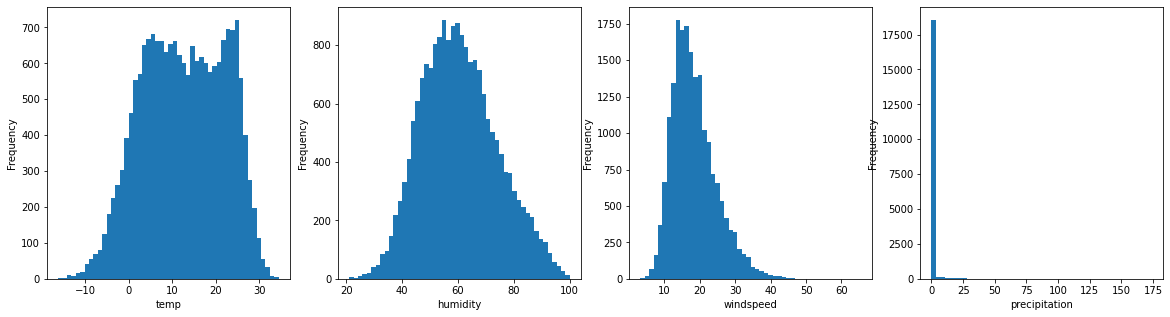

In [67]:
all_outliers = getOutliers(df)

In [68]:
def deleteOutliers(df):
    for col in df.columns:
        if col not in ["year", "month", "day"]:
            print("test")



In [70]:
norm_df = normalize_data(df, good_weather_values)
print("All data - normalized")
norm_df

All data - normalized


,year,month,day,temp,humidity,windspeed,precipitation,pleasant day
0,1970.0,1.0,1.0,0.309392,0.653333,0.880342,1.0,0.710767
1,1970.0,1.0,2.0,0.334254,0.806667,0.779487,1.0,0.730102
2,1970.0,1.0,3.0,0.425414,0.453333,0.887179,1.0,0.691482
3,1970.0,1.0,4.0,0.356354,0.645000,0.813675,1.0,0.703757
4,1970.0,1.0,5.0,0.381215,0.693333,0.784615,1.0,0.714791
...,...,...,...,...,...,...,...,...
19108,2022.0,5.0,23.0,0.988950,0.885000,0.796581,1.0,0.917633
19109,2022.0,5.0,24.0,0.908840,0.700000,0.806838,1.0,0.853919
19110,2022.0,5.0,25.0,0.889503,0.743333,0.894017,1.0,0.881713
19111,2022.0,5.0,26.0,0.922652,0.561667,0.844444,1.0,0.832191


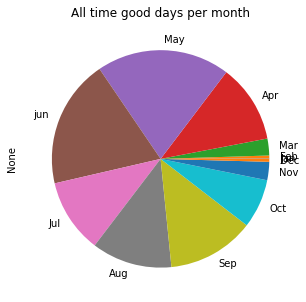

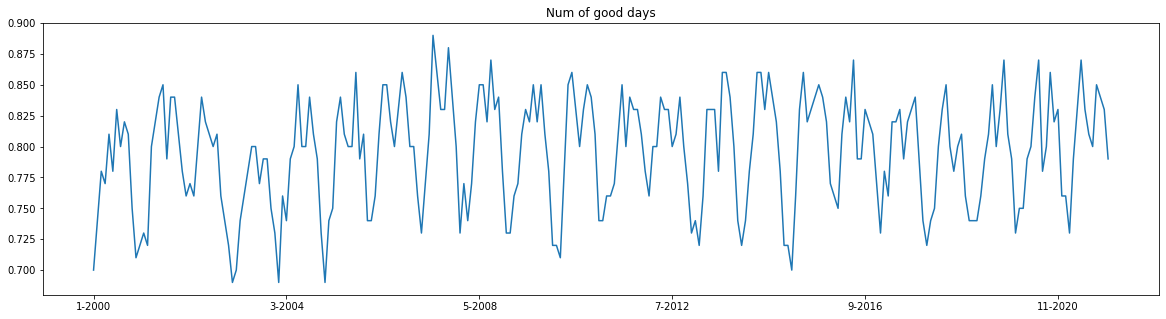

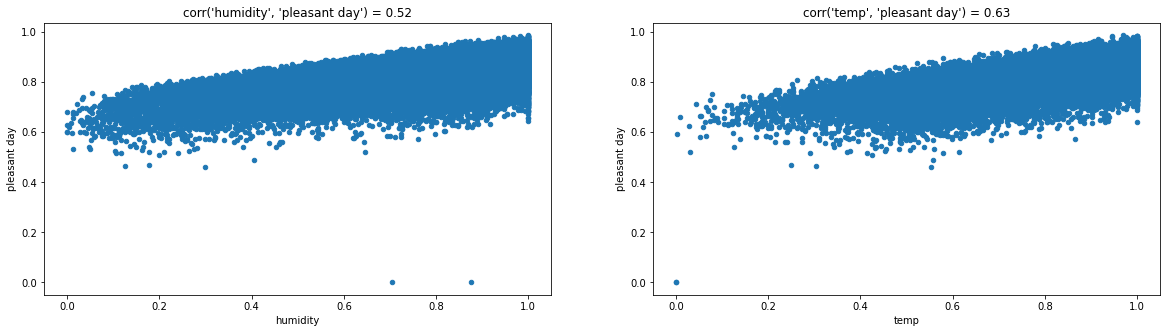

In [69]:
# EDA
num_of_good_days_per_month(norm_df)
num_of_good_days_trends(norm_df)
#num_of_good_days(norm_df)
correlations, tuple_arr = get_highly_correlated_cols(norm_df)
high_correlated_scatters(norm_df)